# 0.0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot   as plt
import random
import pickle
import requests
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")

import xgboost as xgb

from tabulate              import tabulate
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats
from IPython.core.display  import HTML
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression , Lasso
from sklearn.ensemble      import RandomForestRegressor

## 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs(y - yhat) / y)

def mean_percentage_error( y, yhat):
    return np.mean((y - yhat) / y)


def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt( mean_squared_error( y,yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1,kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean( mae_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mae_list ), 2 ).astype( str),
                         'MAPE CV': np.round(np.mean( mape_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mape_list ), 2 ).astype( str),
                         'RMSE CV': np.round(np.mean( rmse_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( rmse_list ), 2 ).astype( str)}, index=[0])



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/data/store.csv',low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left',on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
812392,343,3,2013-07-03,7784,719,1,1,0,0,d,a,18650.0,4.0,2004.0,1,14.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0 DATA DESCRIPTIONS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions 

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0]))
print( 'Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# competition_distance  
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
# promo2_since_week    
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval  
month_map = {1: 'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set',10:'Oct',11:'Nov',12:'Dec'}    

df1['promo_interval'].fillna(0, inplace=True ) 

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0 , axis=1 )


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64' , 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply( np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std)).T
d2 = pd.DataFrame( num_attributes.apply( min)).T
d3 = pd.DataFrame( num_attributes.apply( max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

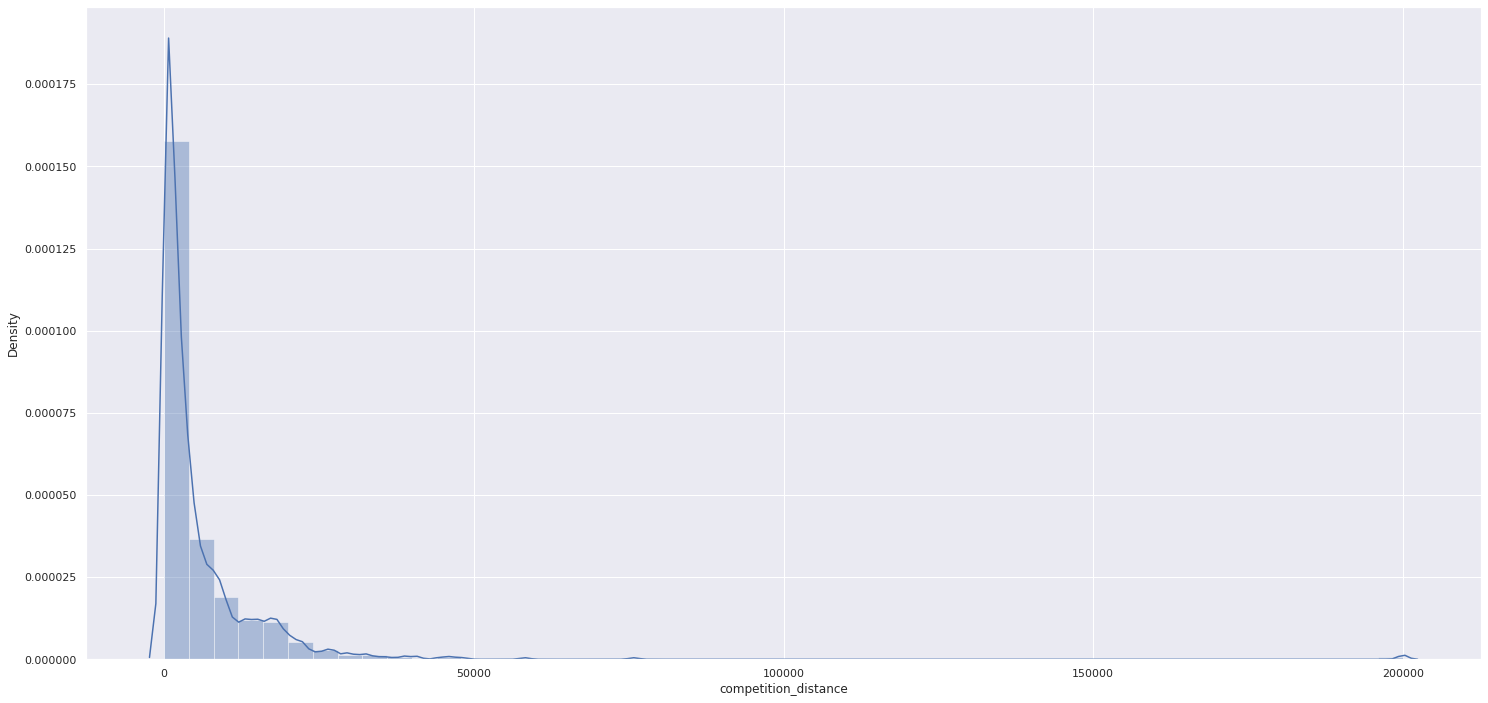

In [16]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

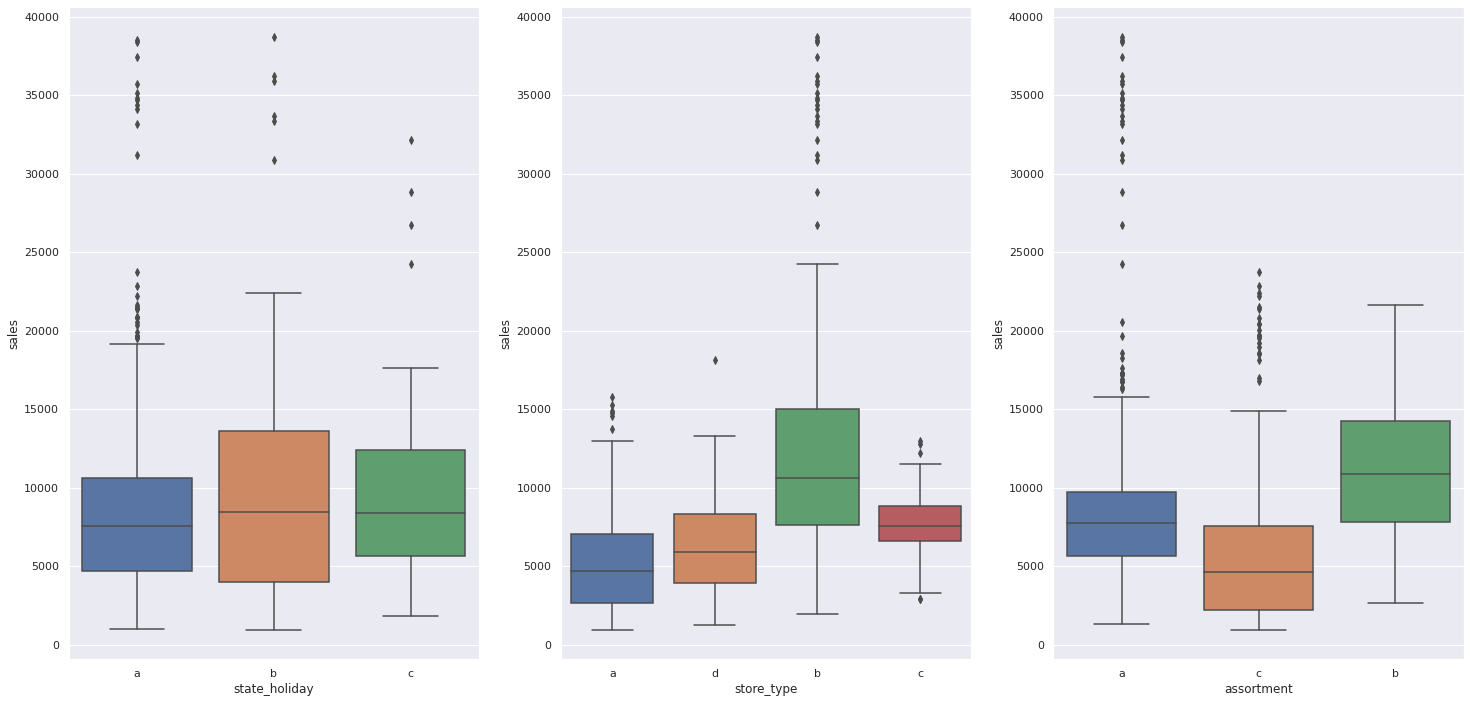

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1,3,1)
sns.boxplot(x='state_holiday' , y='sales' ,data=aux1 )

plt.subplot( 1,3,2)
sns.boxplot(x='store_type' , y='sales' ,data=aux1 )

plt.subplot( 1,3,3)
sns.boxplot(x='assortment' , y='sales' ,data=aux1 )

# 2.0 FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

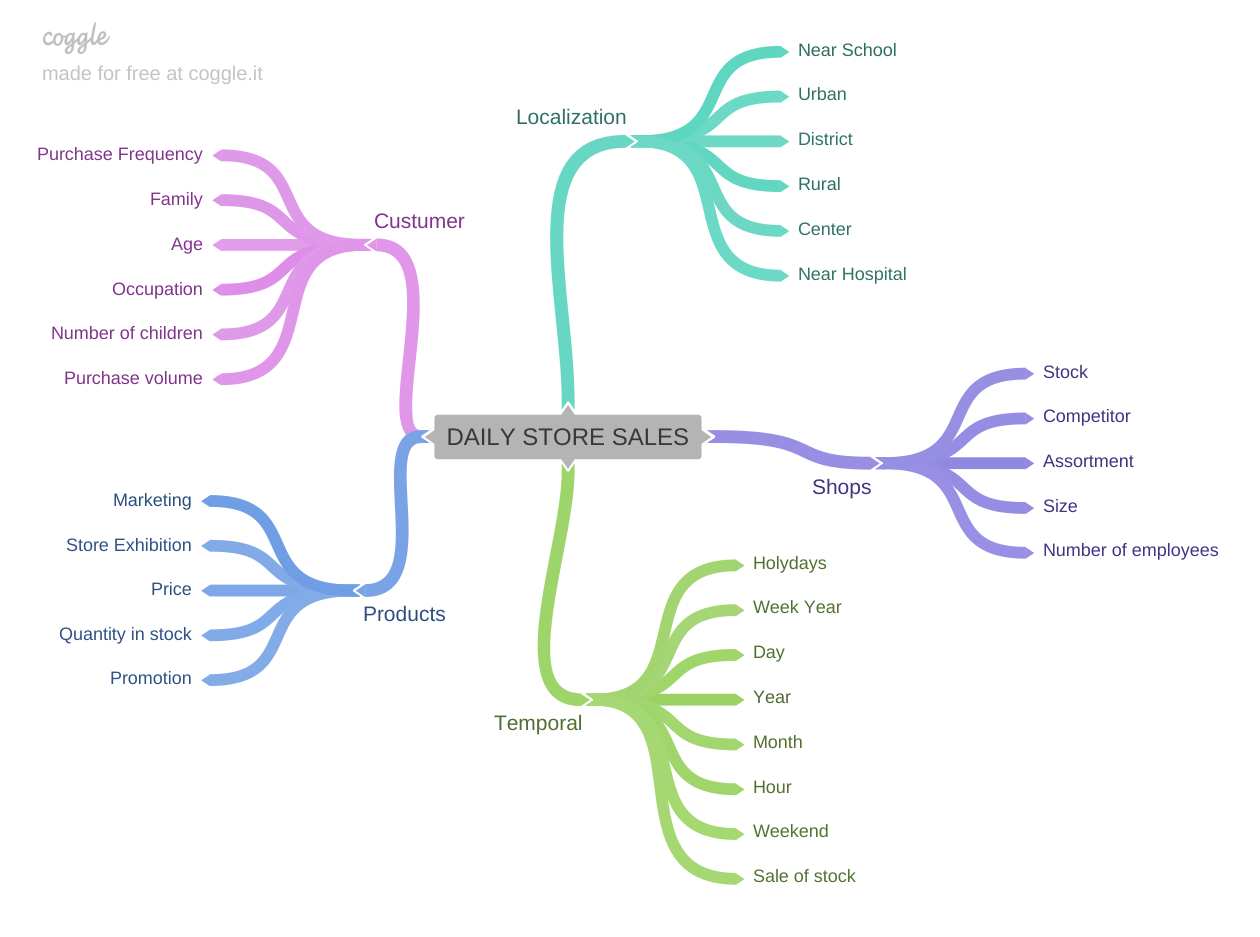

In [20]:
Image( '/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/img/mapmindhipothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Shops Hypothesis

**1.** Stores with larger staff sell more

**2.** Stores with higher stock sell more

**3.** Larger stores should sell more

**4.** Stores with a larger assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with competitors for longer should sell more

### 2.2.2 Products Hypothesis

**1.** Stores that invest more in Marketing should sell more

**2.** Stores that display more of the product in their windows should sell more

**3.** Stores that have lower product prices should sell more

**4.** Stores with more aggressive promotions (larger discounts) should sell more

**5.** Stores with promotions active for longer should sell more

**6.** Stores with more days of promotions should sell more

**7.** Stores with more than consecutive promotions should sell more

### 2.2.3 Temporal Hypothesis

**1.** Stores open during the Christmas holiday should sell more

**2.** Stores should sell more over the years

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

## 2.3 Final List of Hypothesis

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer should sell more


**4.** Stores with promotions active for longer should sell more

**5.** Stores with more days of promotions should sell more

**6.** Stores with more than consecutive promotions should sell more


**7.** Stores open during the Christmas holiday should sell more

**8.** Stores should sell more over the years

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## 2.4 Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , 
                                                                   month=x['competition_open_since_month'], 
                                                                   day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)

#promo since
df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                                             else 'easter_holiday' if x == 'b' 
                                                                             else 'christmas' if x == 'c'
                                                                             else 'regular_day')

In [22]:
df2.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
day_of_week,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185,10457,8959,8821,6544,9191,10231,8430,10071,8234,9593
customers,555,625,821,1498,559,589,1414,833,687,681,1236,962,568,710,766,979,946,936,718,974
open,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
promo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0
store_type,c,a,a,c,a,a,a,a,a,a,a,a,d,a,d,a,a,d,a,d


# 3.0 FILTERING OF VARIABLES


In [23]:
df3 = df2.copy()

In [24]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows Filtering

In [25]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [26]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop( cols_drop, axis=1)

# 4.0 EDA - EXPLORATORY DATA ANALYSIS

In [27]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

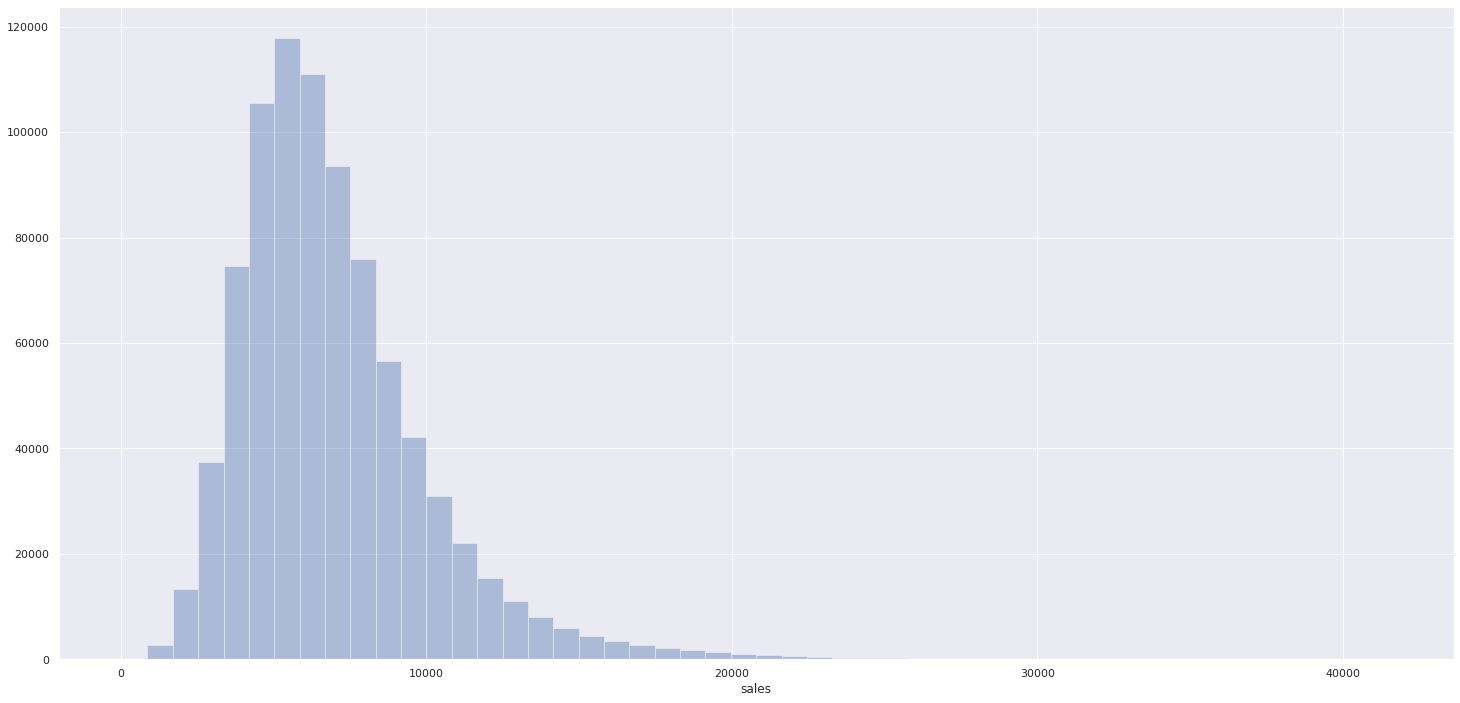

In [28]:
sns.distplot(df4['sales'],kde=False);

### 4.1.2 Numerical Variable

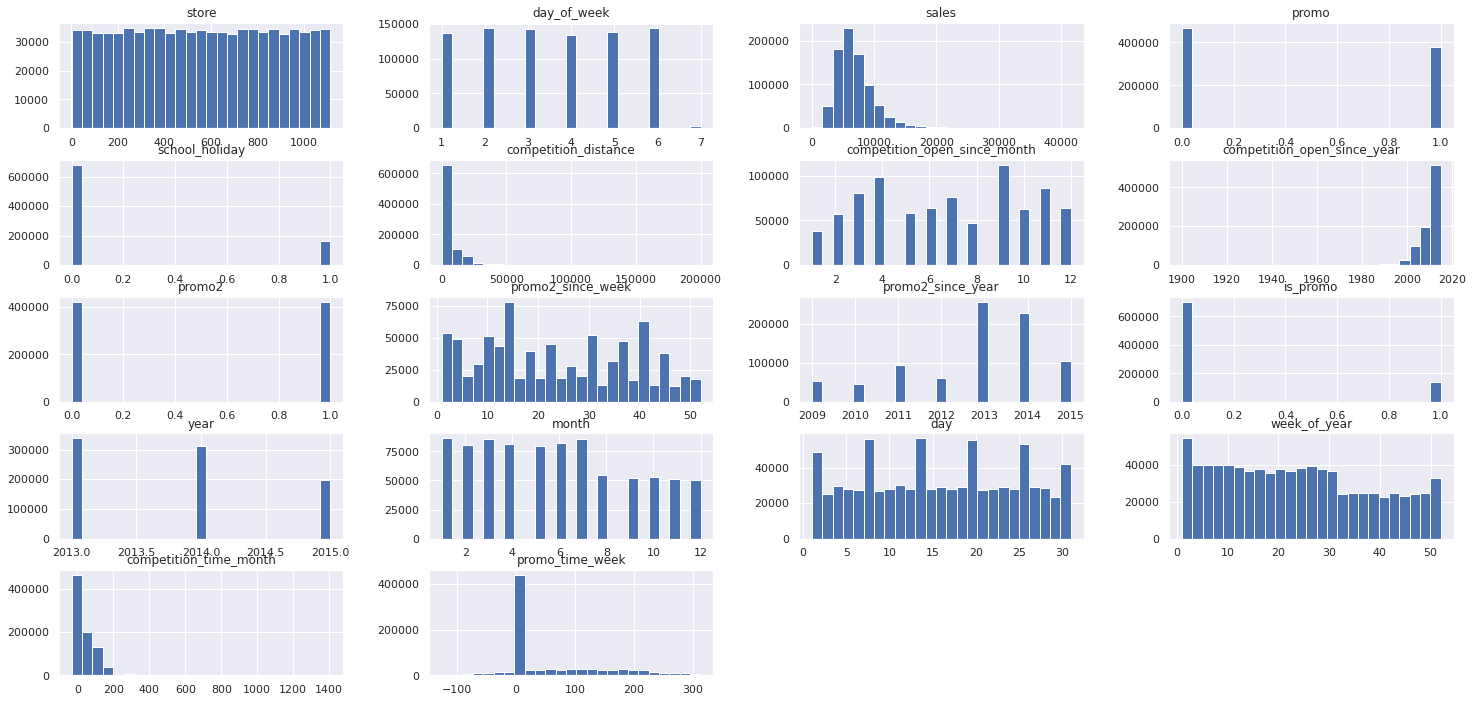

In [29]:
num_attributes = df4.select_dtypes( include=['int64' , 'float64'])
num_attributes.hist(bins=25);

In [ ]:
# day_of_week:  O dia da semana interfere minimamente no volume de vendas
# promo: Há maior volume de vendas quando não há promo
# school_holiday: Volume de vendas é maior quando não há school holiday
# competition_distance: Há uma kurtosis e um skew positivo. Os competidores estão muito próximos
# competition_open_since_month: Há um comportamento de subida de decréscimo constante
# competition_open_since_year: Há uma kurtosis e um skew negativo.
# promo2: Volume de vendas praticamente igual entre os dois indicadores
# promo2_since_week: Há muitas variações ao longo das semanas
# promo2_since_year:  Houve um pico nos anos de 2013 e 2014
# is_promo: Volume de vendas maior quando não há promo

### 4.1.3 Categorical Variable

In [30]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

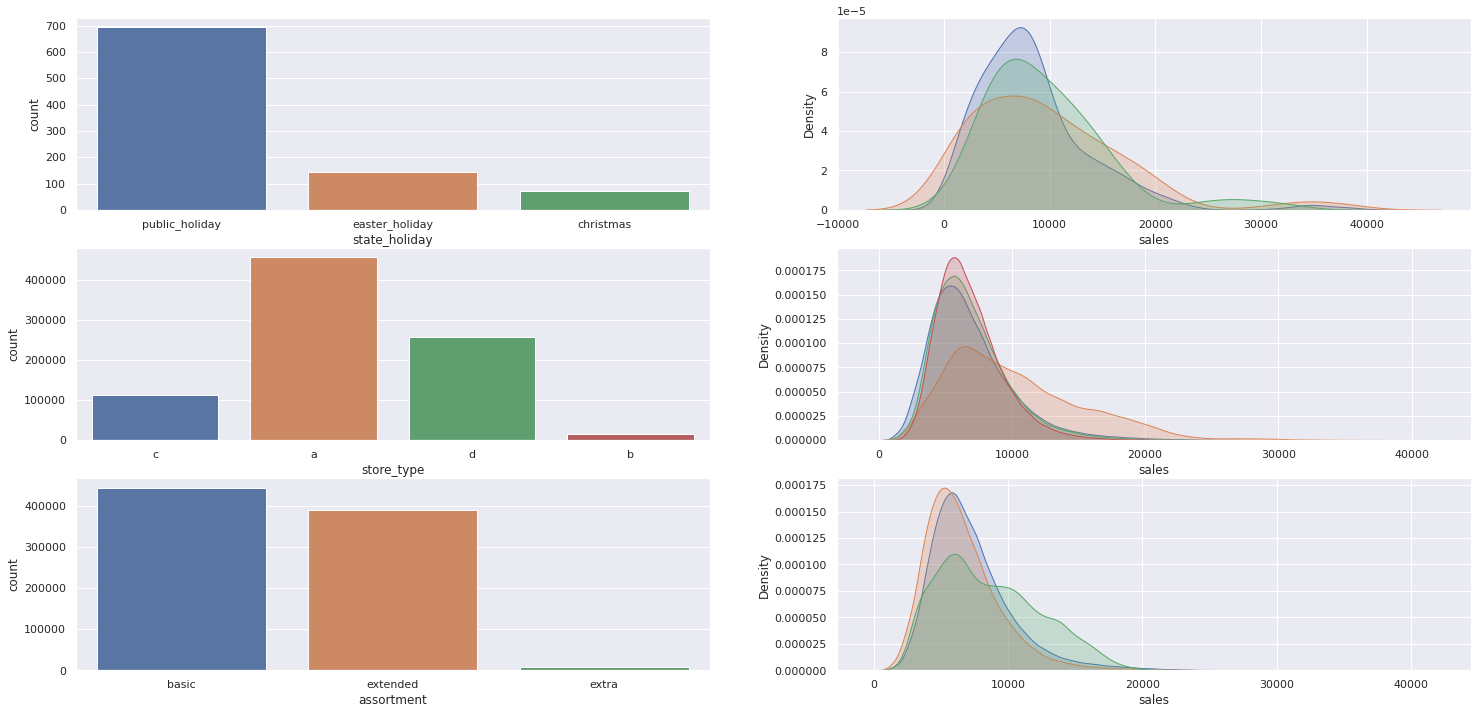

In [31]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True);
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True);
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True);

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True);
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True);

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True);
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True);
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True);


## 4.2 Bivariate Analysis

### H1. Stores with a larger assortment should sell more - FALSE

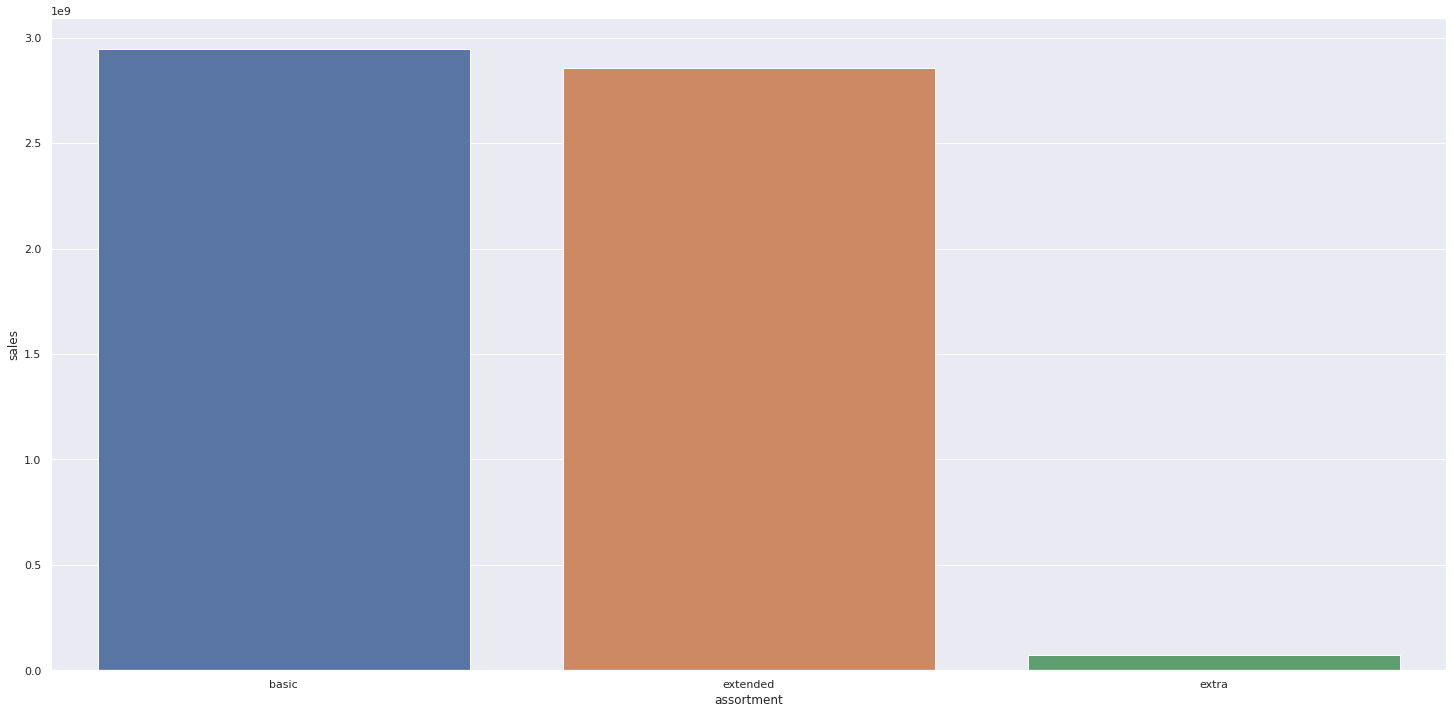

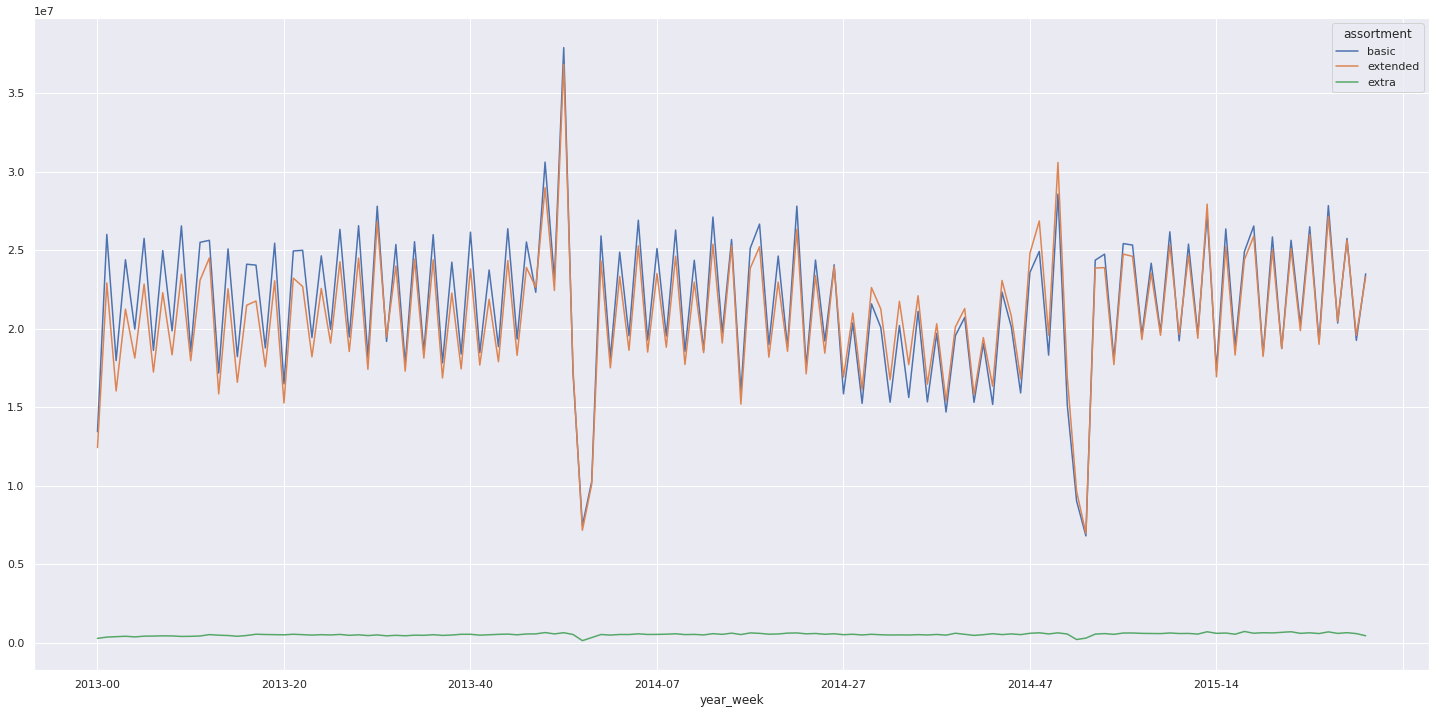

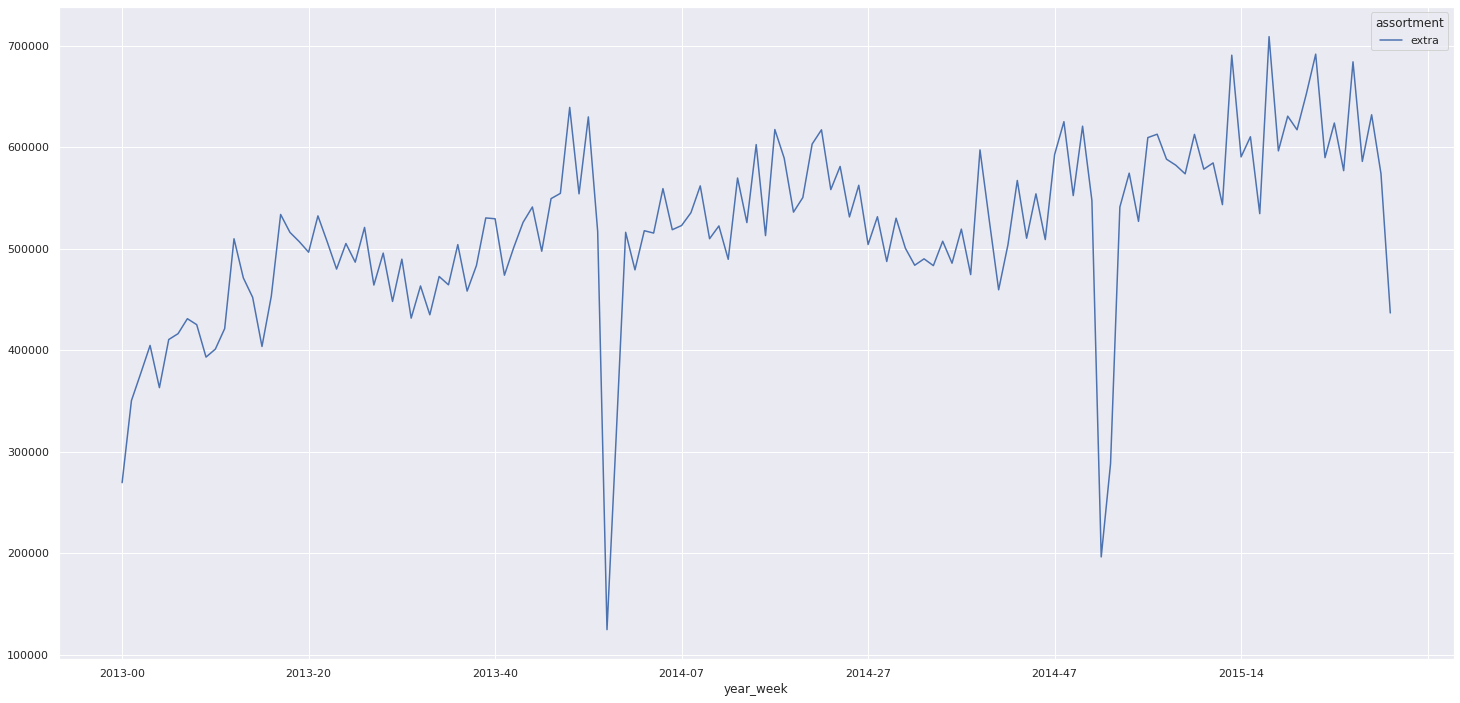

In [32]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data = aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week',columns= 'assortment',values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week',columns= 'assortment',values='sales').plot();

### H2. Stores with closer competitors should sell less - FALSE



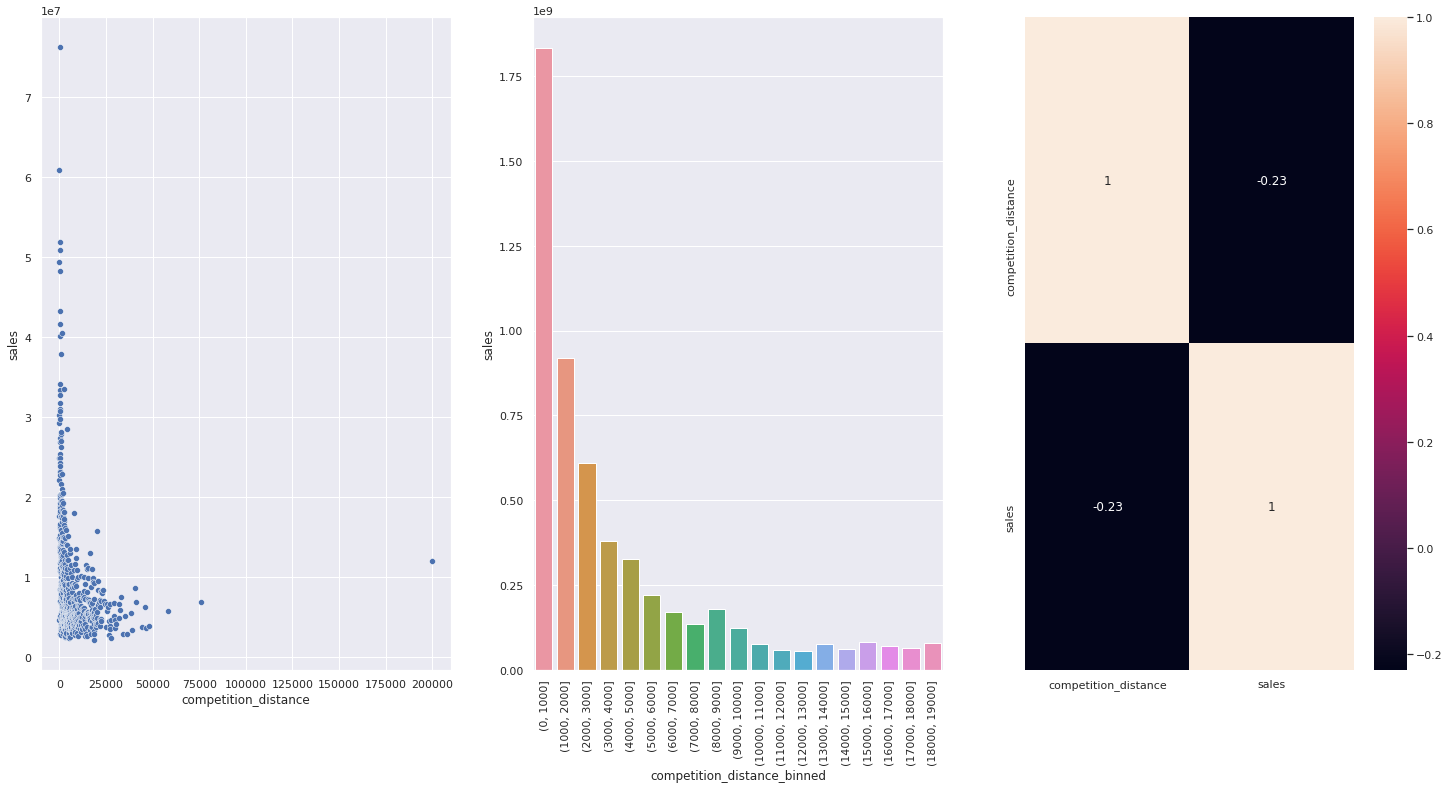

In [33]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Stores with competitors for longer should sell more - FALSE

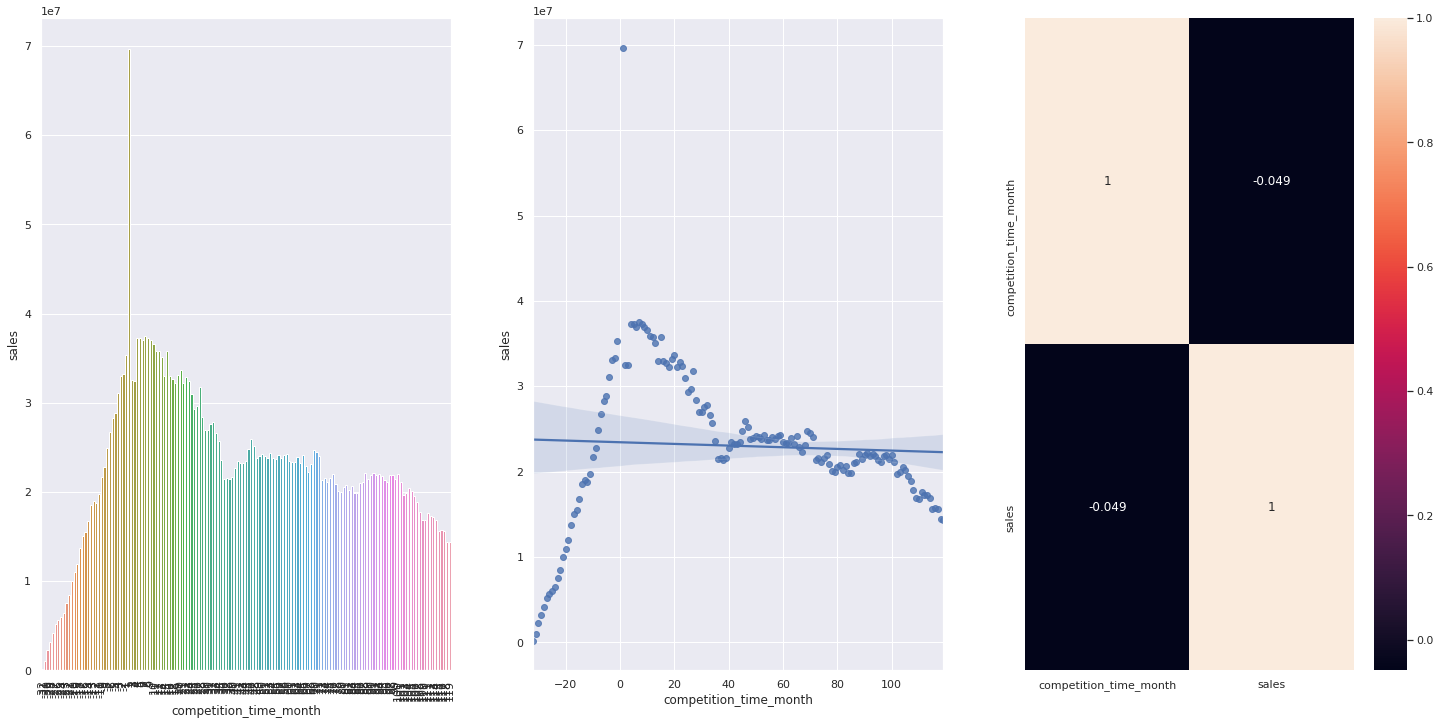

In [34]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);


### H4. Stores with promotions active for longer should sell more - FALSE

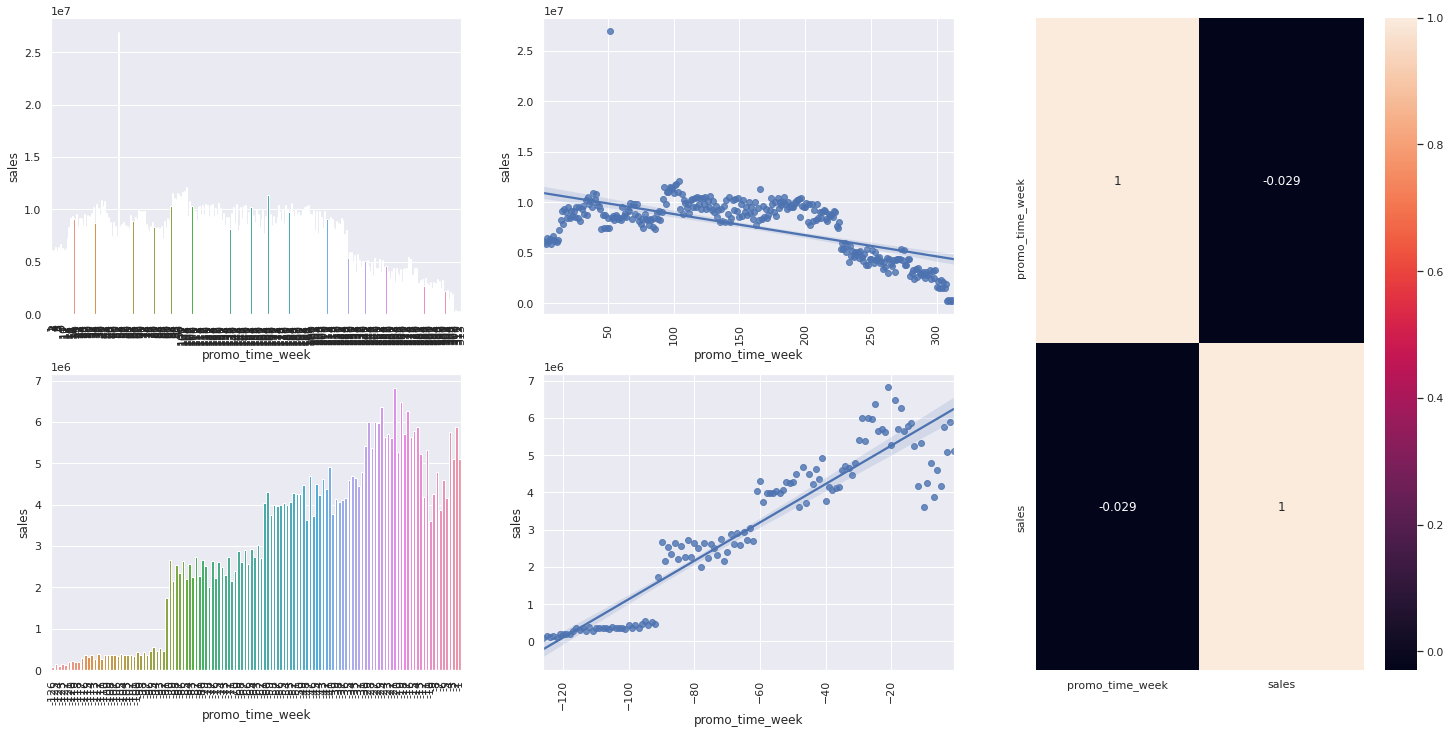

In [35]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'),annot=True);

### <s>H5. Stores with more days of promotions should sell more </s>


### H6. Stores with more than consecutive promotions should sell more - FALSE

In [36]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


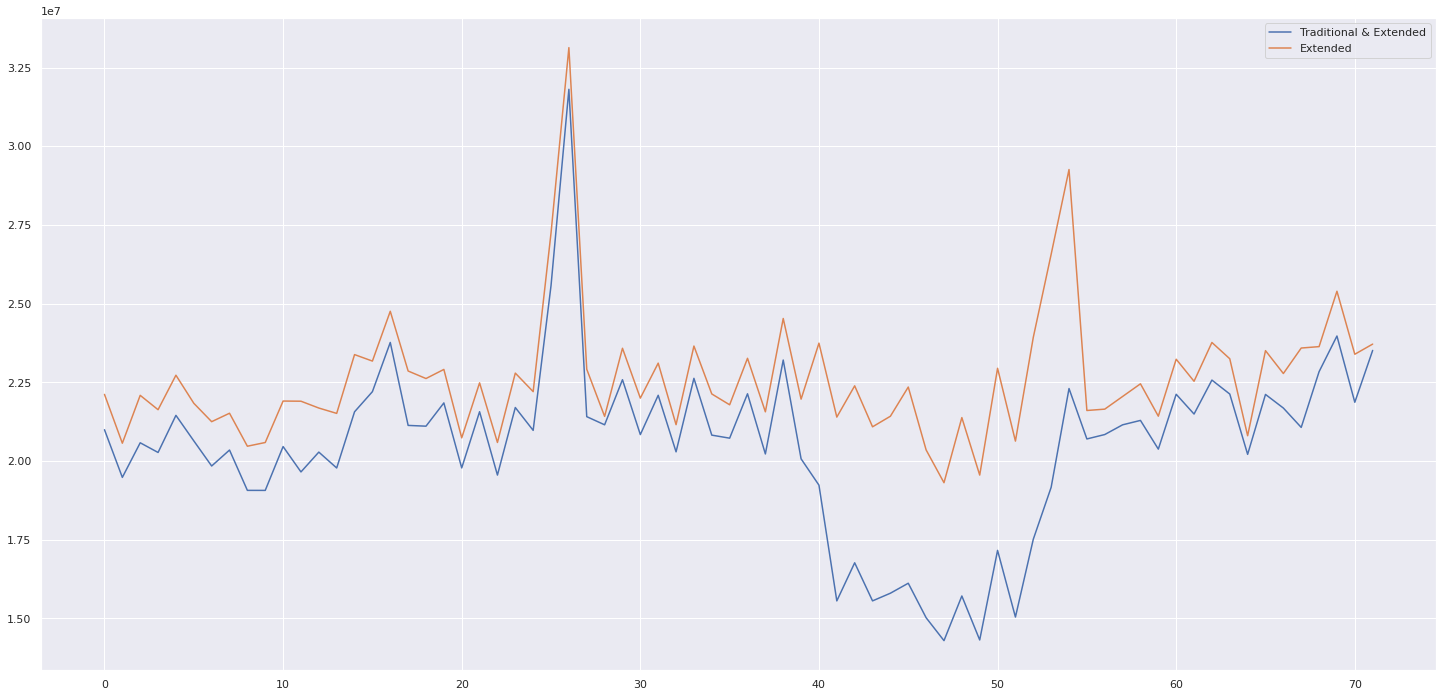

In [37]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend( labels=['Traditional & Extended', 'Extended']);

### H7. Stores open during the Christmas holiday should sell more - FALSE

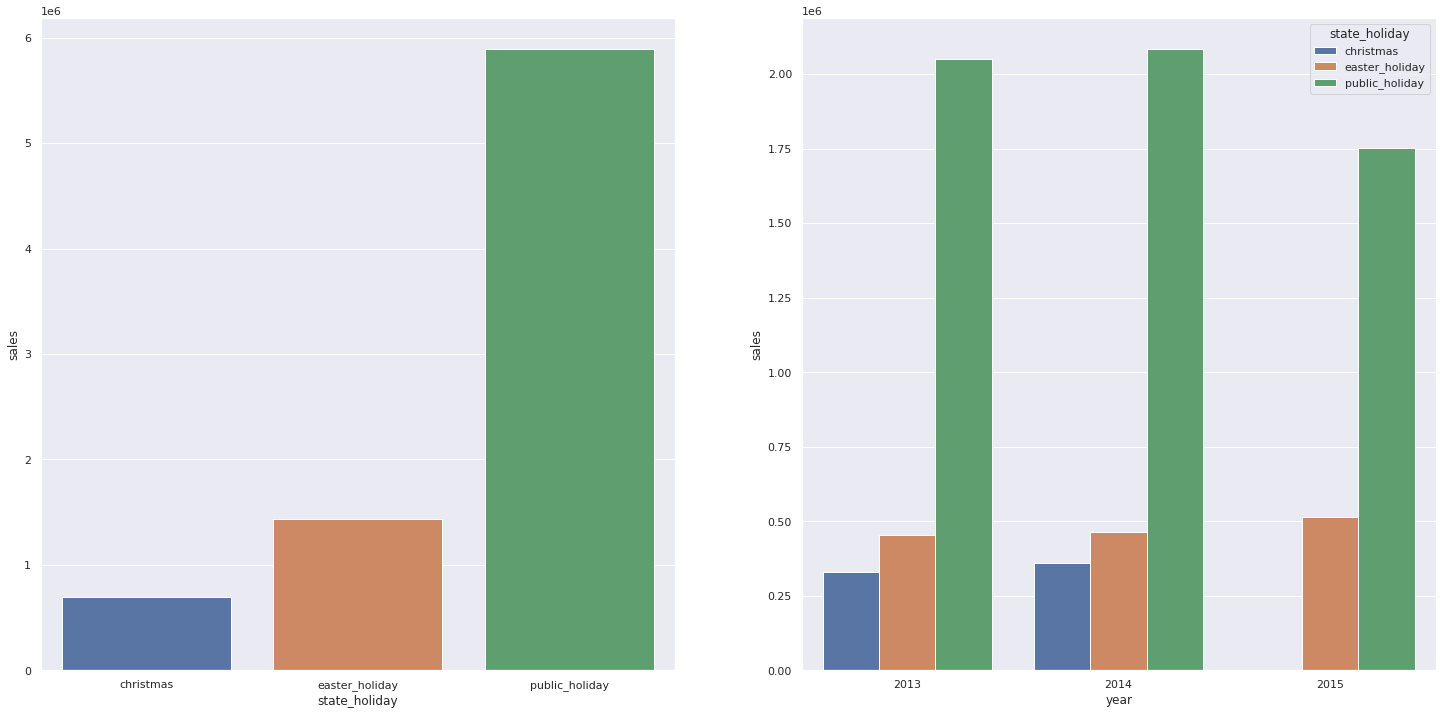

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday' , y='sales', data= aux1);

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x='year' , y='sales', hue='state_holiday' ,data= aux2);

### H8. Stores should sell more over the years - FALSE

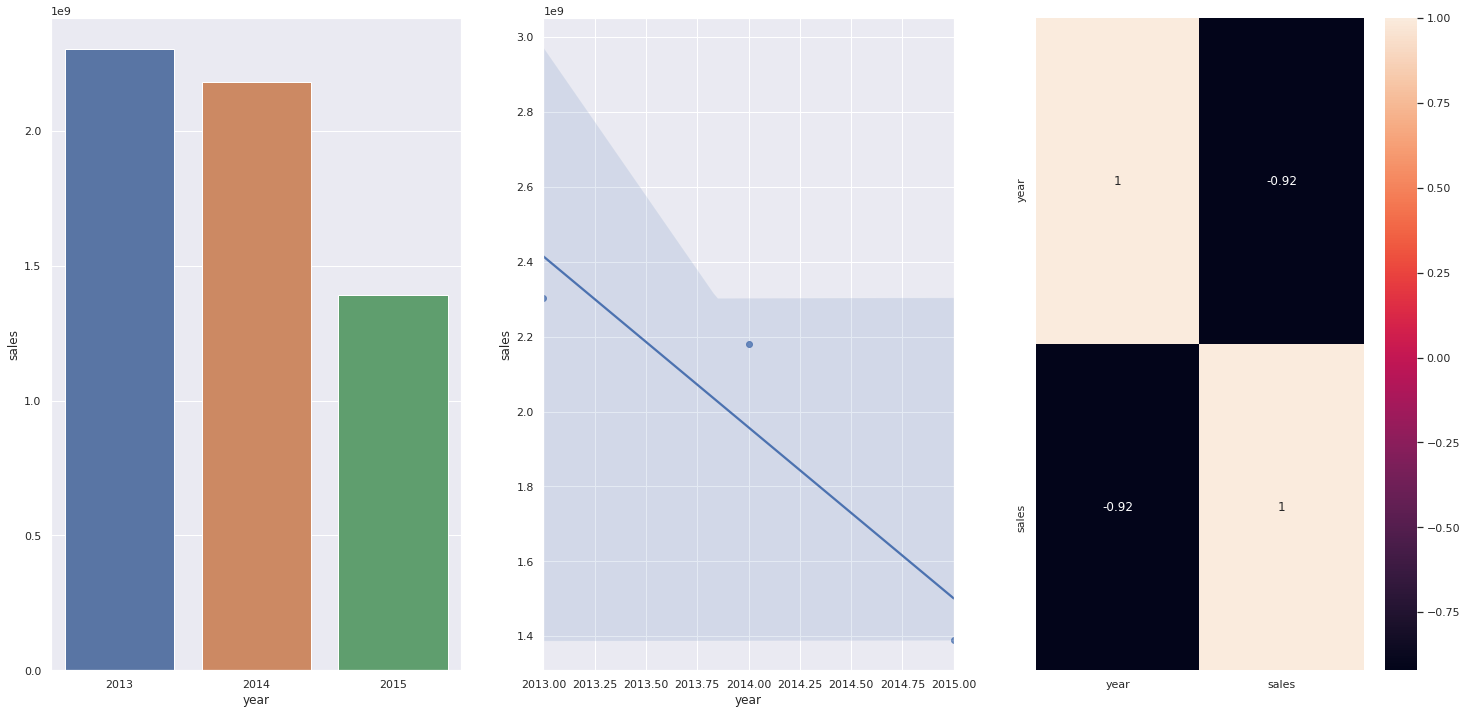

In [39]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H9. Stores should sell more in the second half of the year - FALSE

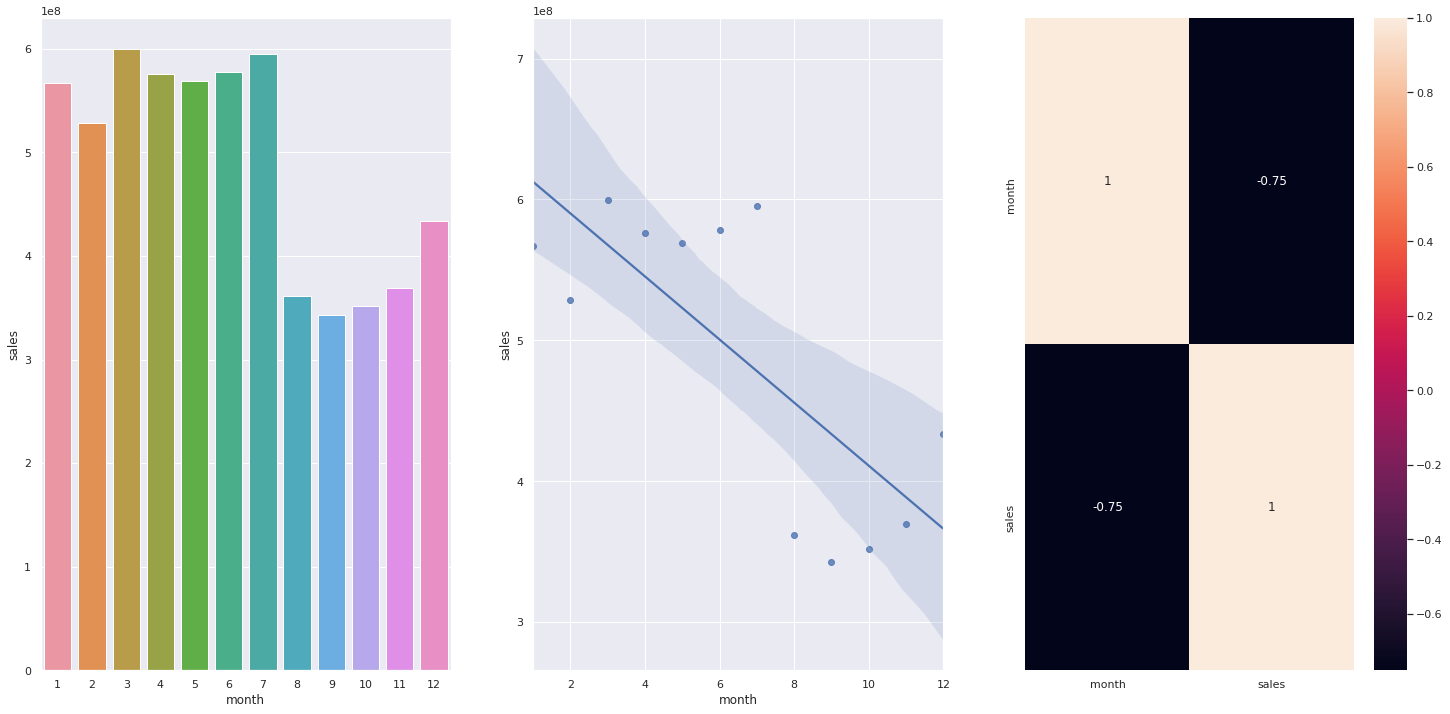

In [40]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H10. Stores should sell more after the 10th of each month - TRUE

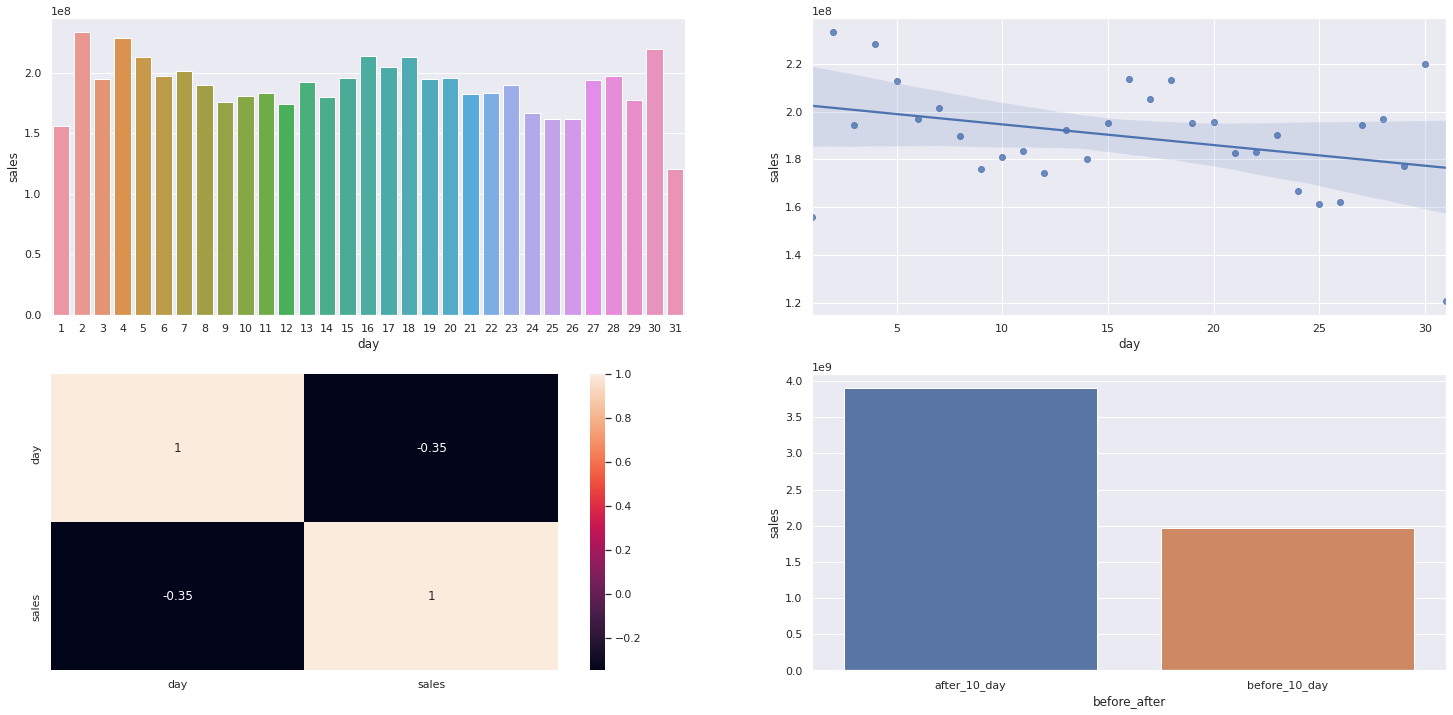

In [41]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,2)
sns.regplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after' , y='sales' , data=aux2);

### H11. Stores should sell less on weekends - TRUE

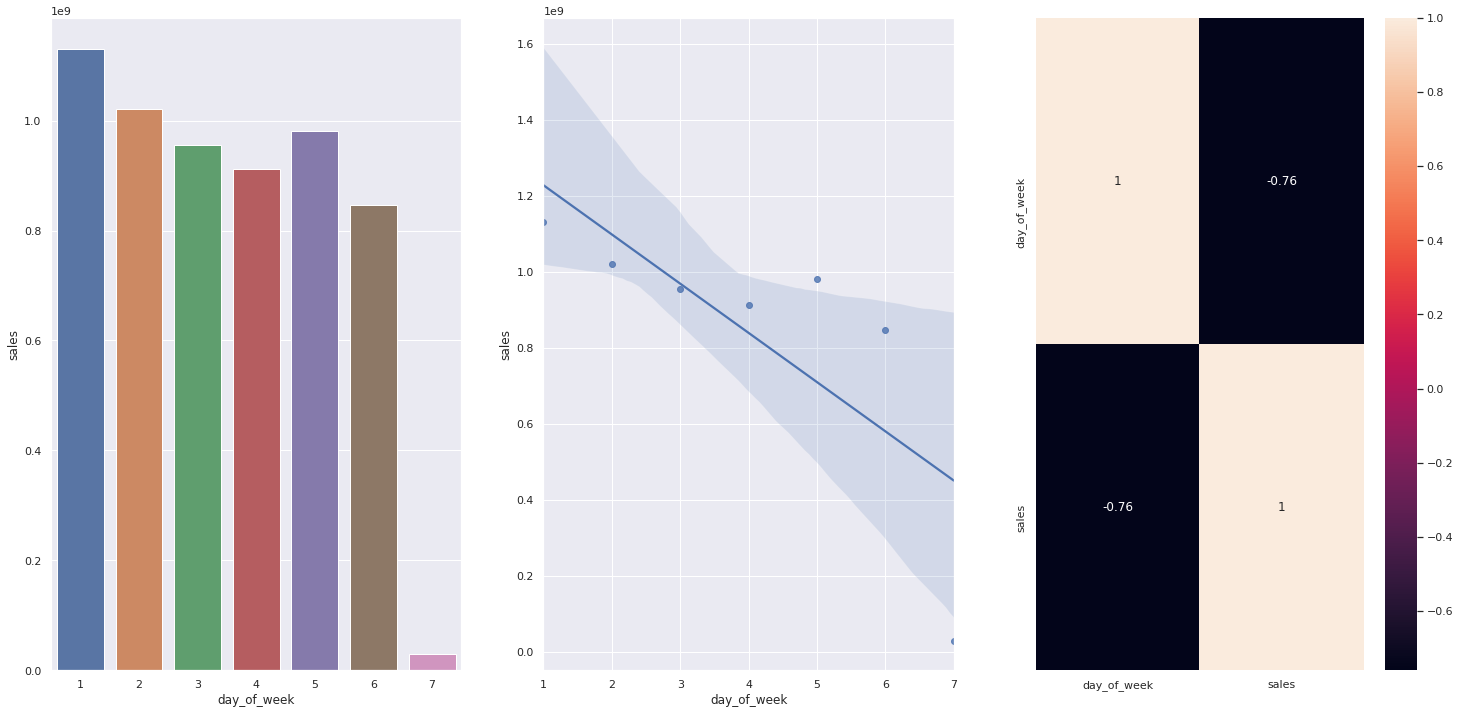

In [42]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H12. Stores should sell less during school holidays - TRUE, EXCEPT JULY AND AUGUST

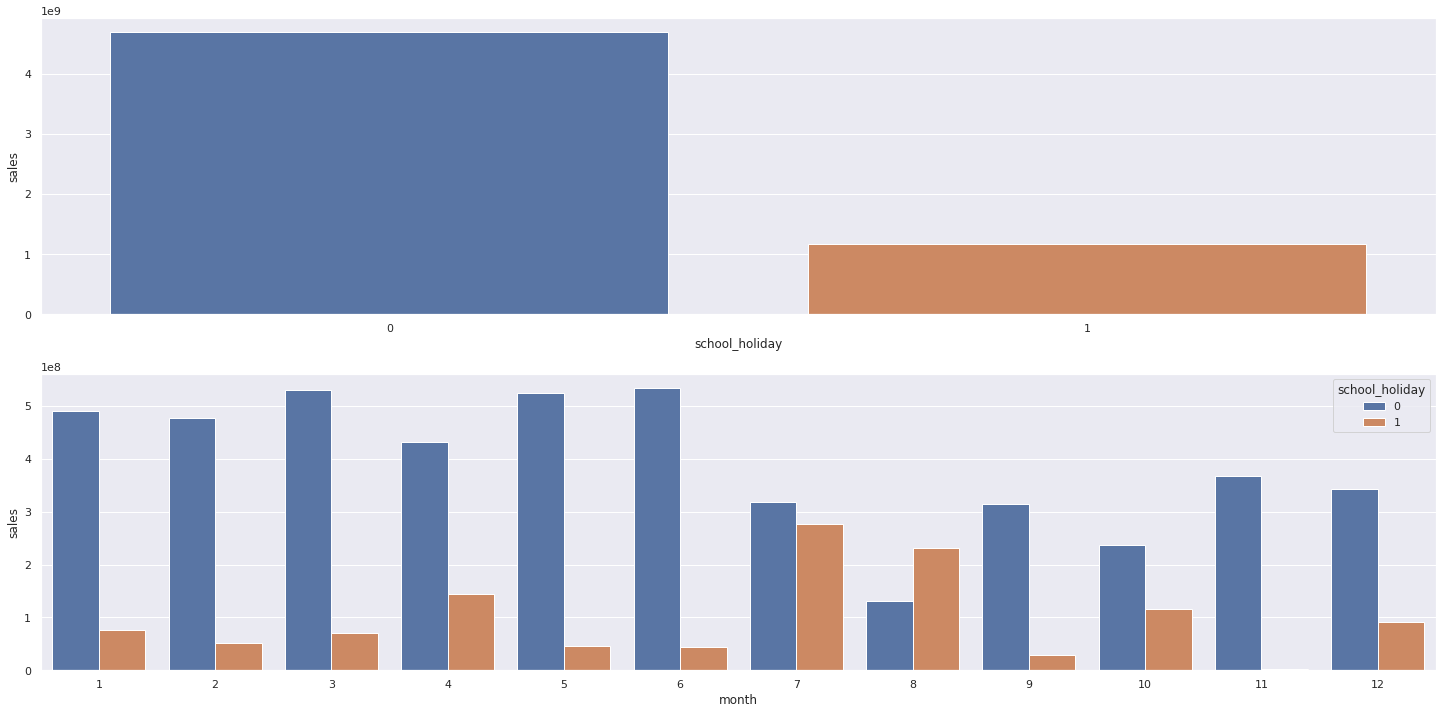

In [43]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday' , y='sales' , data=aux1 );

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month' , y='sales' , hue='school_holiday', data=aux2 );

### 4.2.1 Hypotesis Resume

In [44]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Average'],
      ['H3', 'False', 'Average'],  
      ['H4', 'False', 'Low'], 
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Average'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           False         Low
H2           False         Average
H3           False         Average
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Average
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          Low


## 4.3 Multivariate Analysis


### 4.3.1 Numerical Attributes

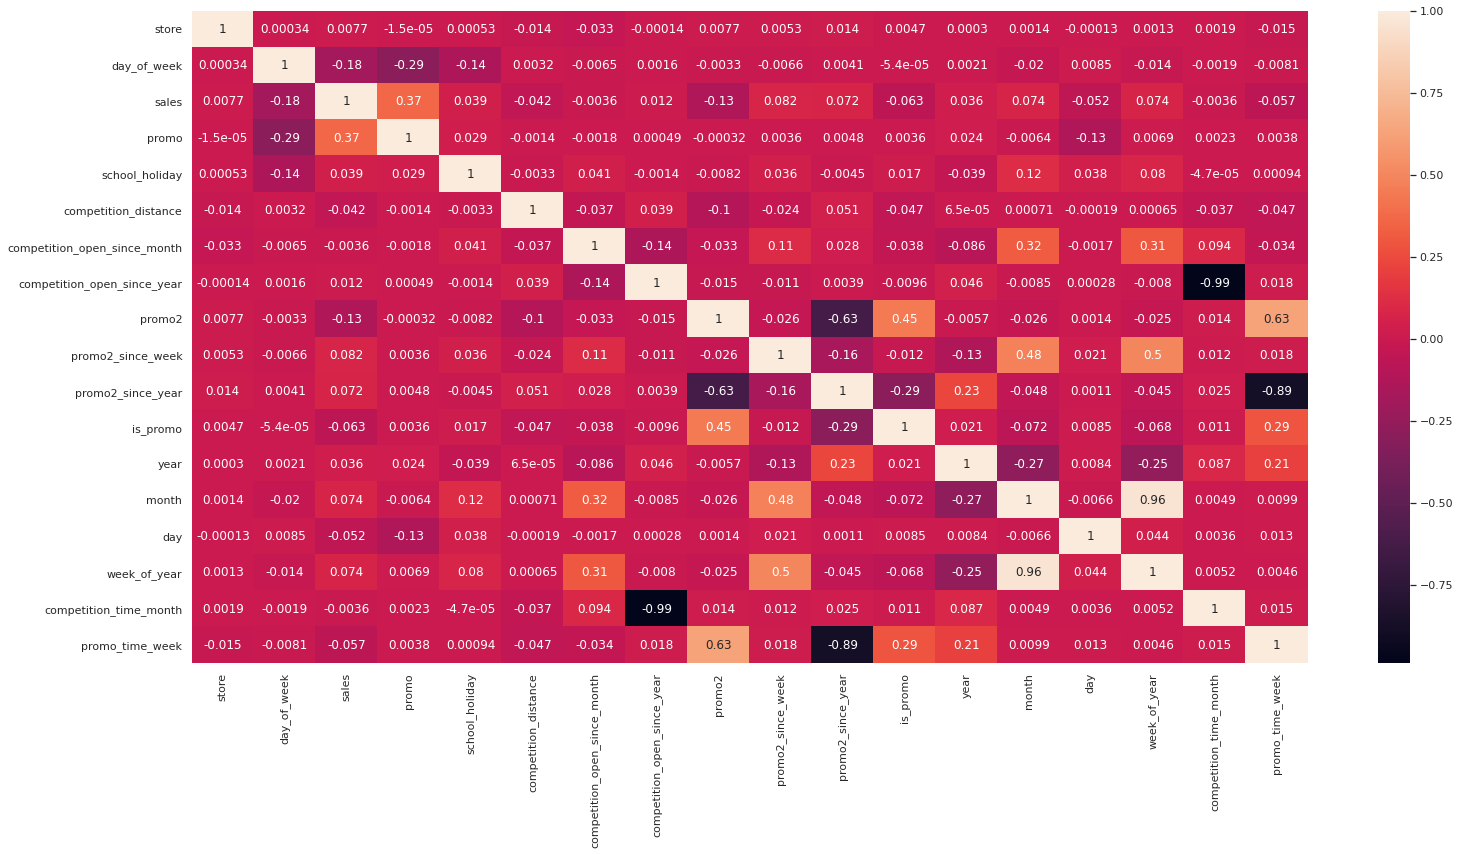

In [45]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

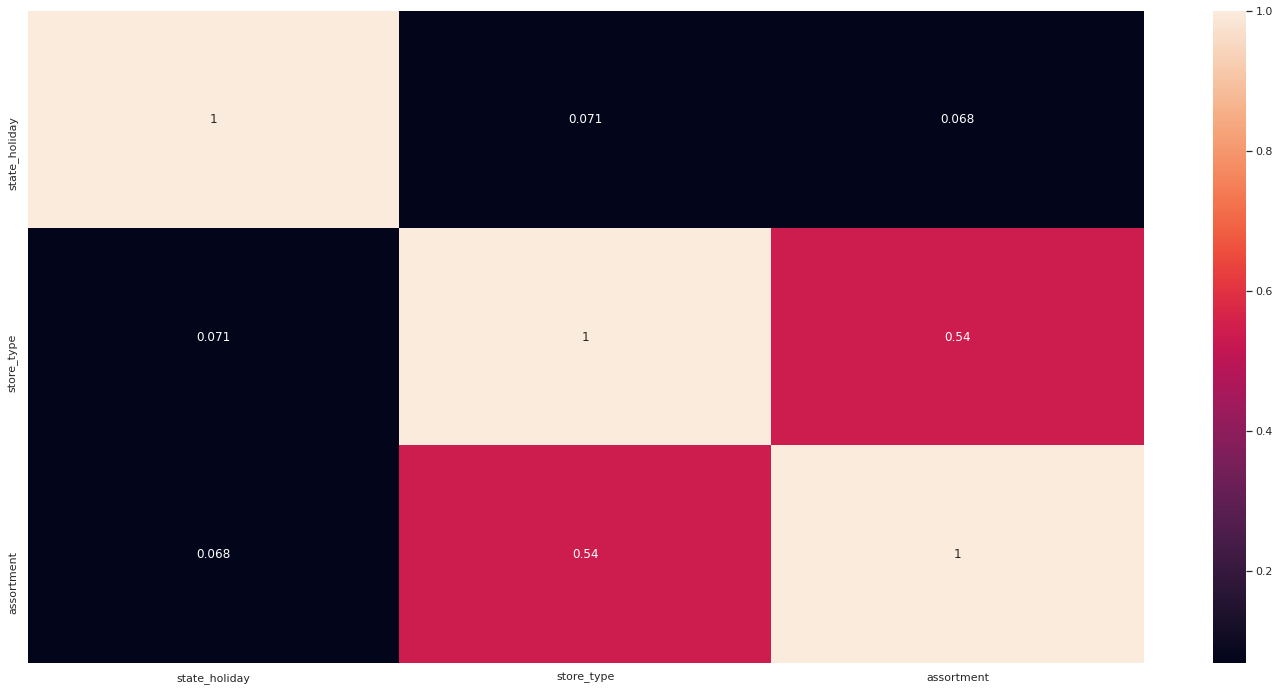

In [46]:
# only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] } )

d = d.set_index( d.columns)

sns.heatmap(d, annot=True);

# 5.0 DATA PREPARATION

In [48]:
df5 = df4.copy()

## 5.1 Normalization

In [ ]:
# There are not normal variables to normalize

## 5.2 Rescaling

In [49]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/parameter/year_scaler.pkl', 'wb') )

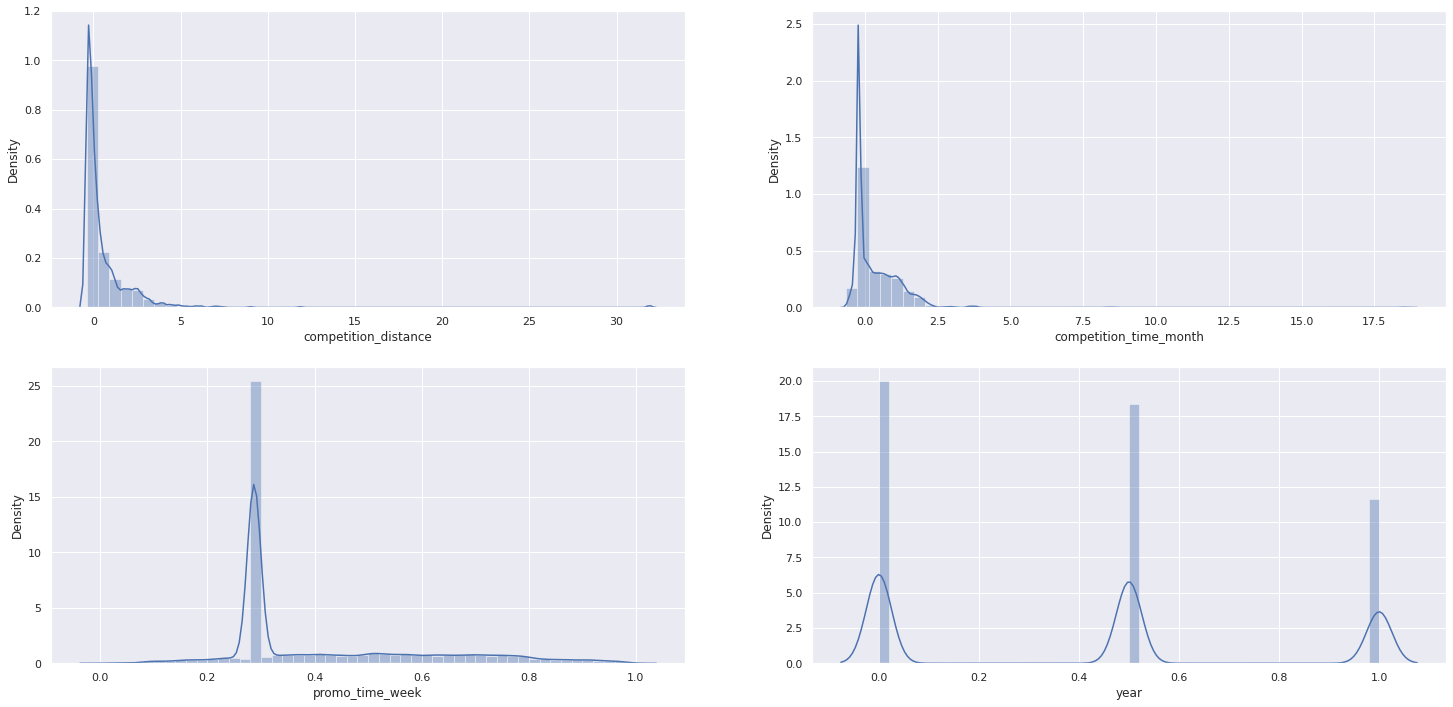

In [50]:
plt.subplot(2,2,1)
sns.distplot(df5['competition_distance']);

plt.subplot(2,2,2)
sns.distplot(df5['competition_time_month']);

plt.subplot(2,2,3)
sns.distplot(df5['promo_time_week']);

plt.subplot(2,2,4)
sns.distplot(df5['year']);

## 5.3 Transformation

### 5.3.1 Encoding

In [51]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'],columns= ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( '/home/felipe_rastelli/repositorios/DataScience_Em_Producao/FR-Rossmann_Sales_Model/parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

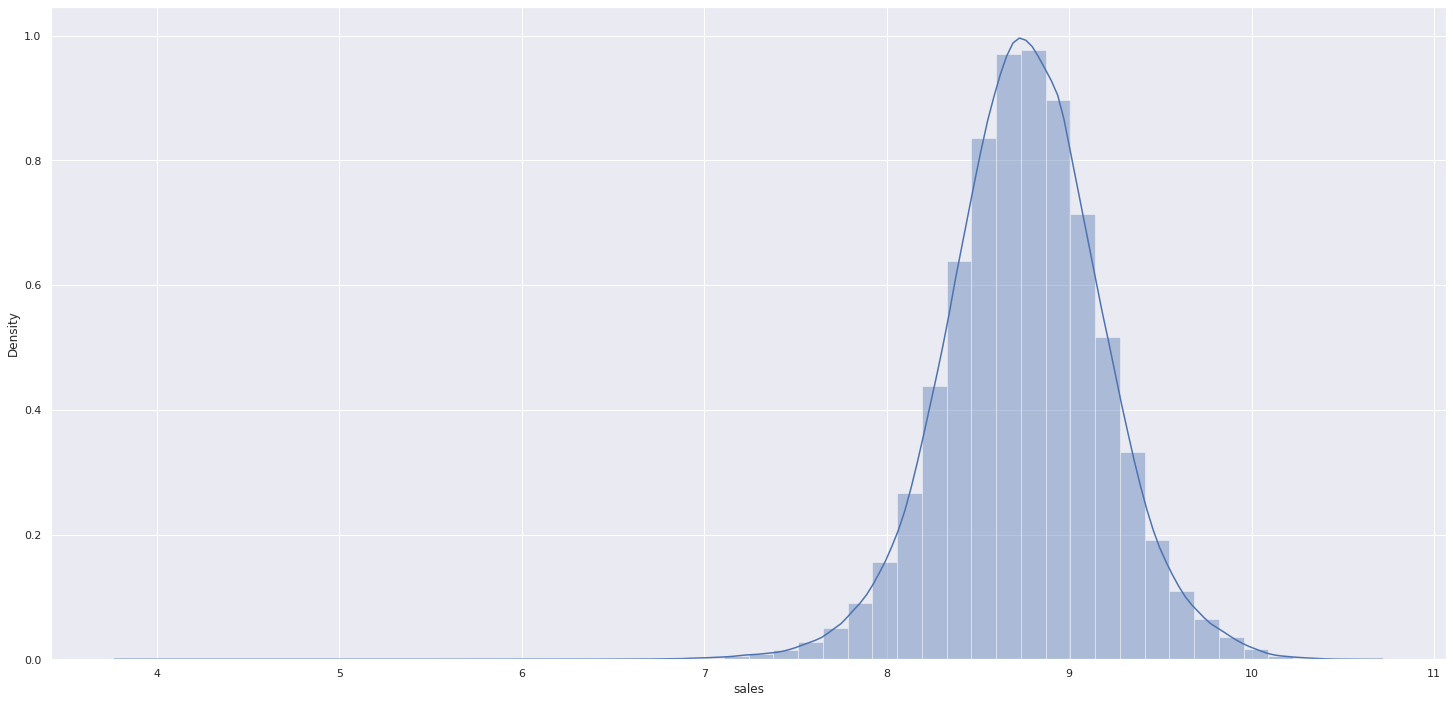

In [52]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales']);

### 5.3.3 Nature Transformation

In [53]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )


# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

In [ ]:
# df6 = df6.sample(50000)

## 6.1 Split dataframe into training and test dataset

In [55]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop (cols_drop , axis=1)

In [56]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days =6*7 )

Timestamp('2015-06-19 00:00:00')

In [57]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
# X_train_n = X_train.drop(['date','sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n , y_train_n)

## 6.2.1 Best Features from Boruta

In [ ]:
# cols_selected = boruta.support_.tolist()

# best features
# X_train_fs = X_train.drop(['date','sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
# cols_not_selected = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3 Manual Feature Selection

In [58]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELING

In [59]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [ ]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store' , 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
# aux1 = pd.merge( aux1, aux2 , how='left', on='store')
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
# baseline_result

## 7.2 Linear Regression Model

In [ ]:
# # model
# lr = LinearRegression().fit( x_train, y_train)

# # prediction
# yhat_lr = lr.predict( x_test )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1(y_test) , np.expm1(yhat_lr) )
# lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv

## 7.3 Linear Regression Regularized Model

In [ ]:
# # model
# lrr = Lasso( alpha=0.01 ).fit( x_train, y_train)

# # prediction
# yhat_lrr = lrr.predict( x_test )

# # performance
# lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test) , np.expm1(yhat_lrr) )
# lrr_result

### 7.3.1 Lasso - Cross Validation

In [ ]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

## 7.4 Random Forest Regressor

In [ ]:
# # model
# rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# # prediction
# yhat_rf = rf.predict( x_test )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(yhat_rf) )
# rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5 XGBoost Regressor

In [60]:
# # model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train)      

# # prediction
yhat_xgb = model_xgb.predict( x_test )

# # performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,890.527565,0.129193,1306.496922


### 7.5.1 XGBoost Regressor - Cross Validation

In [61]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.45 +/- 172.04,0.14 +/- 0.02,1513.27 +/- 234.33


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [ ]:
# param = {
#        'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01 , 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytree': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15] 
#         }

# MAX_EVAL = 10

In [ ]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL):
#      # choose values for parameters randomly
#      hp = {k: random.sample( v, 1)[0]for k, v in param.items() }
#      print( hp )
    
# #     # model
#      model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
    
# #     # performance
#      result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#      final_result = pd.concat([final_result, result])
    
# final_result

## 8.2 Final Model

In [62]:
param_tuned = {
      'n_estimators':2500 ,
      'eta': 0.01 ,
      'max_depth': 9,
      'subsample':0.5 ,
      'colsample_bytree':0.3 ,
      'min_child_weight':8 
       }

In [63]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train)   
    
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,673.394631,0.097298,965.731681


In [64]:
# MPE Calc
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.010419652799255295

# 9.0 ERROR TRANSLATION AND INTERPRETATION

In [65]:
df9 = X_test[cols_selected_boruta_full]

# rescale

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [66]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [67]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103188.937500,99962.693154,106415.181846,3226.244346,0.533263
908,909,248756.421875,241156.887674,256355.956076,7599.534201,0.531823
875,876,201189.531250,197130.664073,205248.398427,4058.867177,0.296261
721,722,344103.843750,342332.487885,345875.199615,1771.355865,0.232605
273,274,199474.703125,198204.915039,200744.491211,1269.788086,0.217875


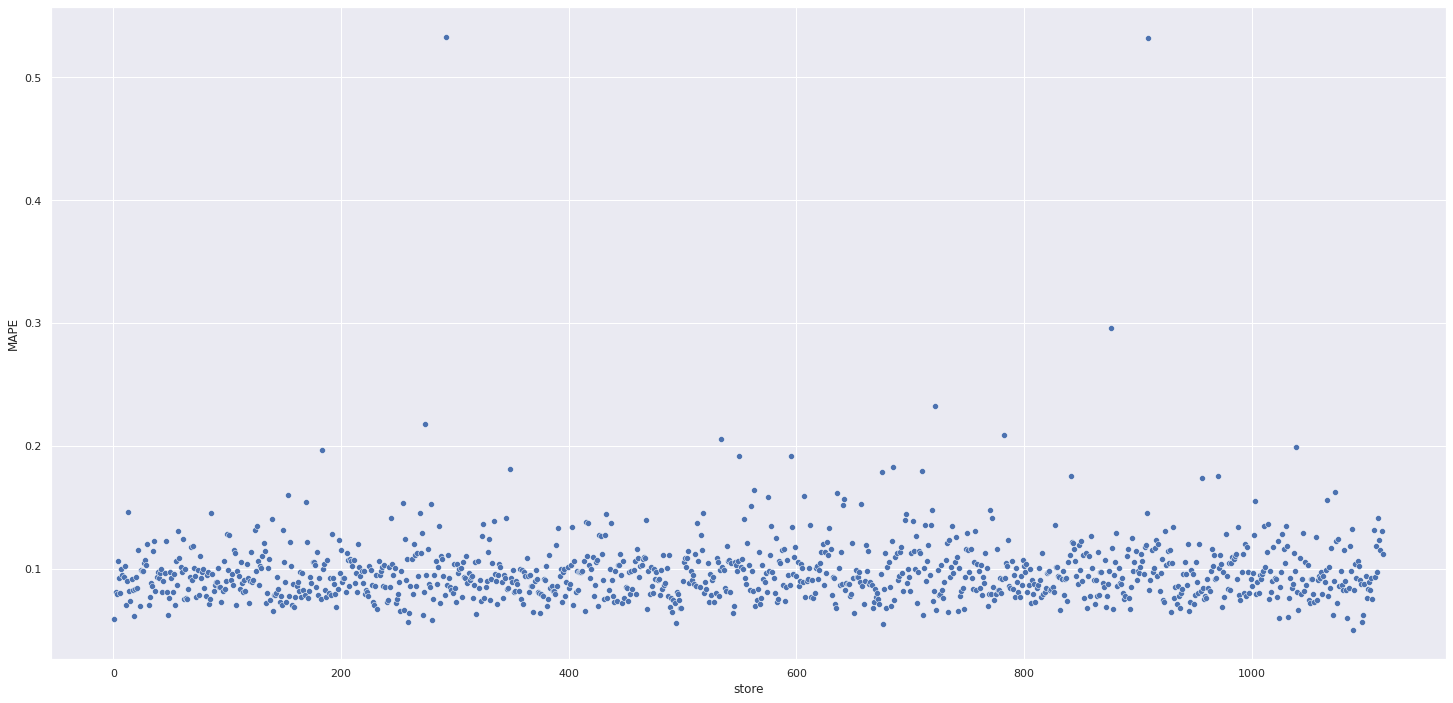

In [68]:
sns.scatterplot( x='store', y='MAPE', data=df92);

## 9.2 Total Performance

In [69]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum( x ), axis=0).reset_index().rename( columns={'index':'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map( 'US$ {:,.2f}'.format )
df93

,Scenarios,Values
0,predictions,"US$ 282,662,848.00"
1,worst_scenario,"US$ 281,907,880.11"
2,best_scenario,"US$ 283,417,771.65"


## 9.3 Machine Learning Performance

In [70]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

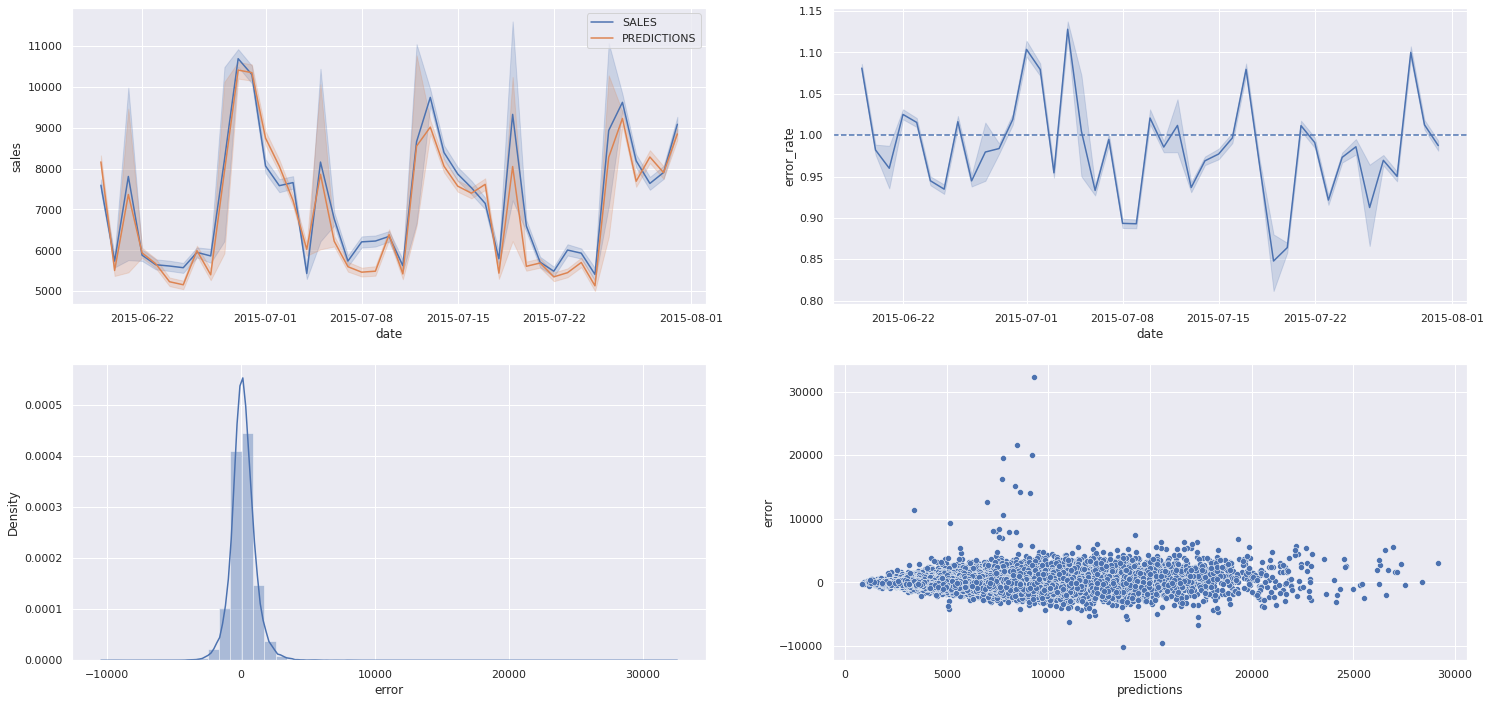

In [71]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES');
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot( 2, 2, 2 ) 
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error']);

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

# 10.0 DEPLOY MODEL TO PRODUCTION

In [ ]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
   
    def __init__( self ):
        self.home_path= '/home/felipe_rastelli/repositorios/DataScience_Em_Producao/'
        self.competition_distance_scaler    = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler  = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler         = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                    = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler              = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
        state = 1
    
    def data_cleaning( self, df1):
        
        # Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                'CompetitionDistance', 'CompetitionOpenSinceMonth',
                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map( snakecase, cols_old))

        # Rename
        df1.columns = cols_new

        # Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        # Fillout NA

        # competition_distance  
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month  
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week    
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year 
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval  
        month_map = {1: 'Jan', 2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set',10:'Oct',11:'Nov',12:'Dec'}        
        df1['promo_interval'].fillna(0, inplace=True ) 
        df1['month_map'] = df1['date'].dt.month.map( month_map)
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0 , axis=1 )

        # Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering( self, df2):
        
        # Feature Engineering
        
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , 
                                                                           month=x['competition_open_since_month'], 
                                                                           day=1), axis=1)
        
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] =  df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ))
        
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                                                     else 'easter_holiday' if x == 'b' 
                                                                                     else 'christmas' if x == 'c'
                                                                                     else 'regular_day')
        
        # Rows Filtering
        df2 = df2[df2['open']!= 0]
       
        # Columns Selection
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop( cols_drop, axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
        
        # Rescaling        
        
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
   
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
       
        # Encoding
        
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix= ['state_holiday'],columns= ['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1,'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # Nature Transformation
        
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2. * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2. * np.pi/30) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2. * np.pi/52) ) )
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                                 'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                                 'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos',
                                 'week_of_year_sin','week_of_year_cos']

        return df5[cols_selected]
           
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )


## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask                import Flask, request, Response
from rossmann.Rossmann    import Rossmann

# Loading Model
model = pickle.load( open( '/home/felipe_rastelli/repositorios/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') )

# Initialize API
app = Flask(__name__)

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        
        if isinstance( test_json, dict):        
            test_raw = pd.DataFrame( test_json, index=[0]) #unique example
            
        else:        
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys()) #multiple example
    
        # Instantiate Rossmann class
        pipeline = Rossmann()

        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # Feature Engineering
        df2 = pipeline.feature_engineering ( df1 )

        # Data preparation
        df3 = pipeline.data_preparation ( df2 )

        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return df_response
        
    else:
        return Reponse( '{}' , status=200, mimetype='application/json' )
        

if __name__ =='__main__':
    app.run( '0.0.0.0')

## 10.3 API Tester

In [ ]:
# Loading test dataset
df10 = pd.read_csv('/home/felipe_rastelli/repositorios/DataScience_Em_Producao/data/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Choose store for prediction
# df_test = df_test[df_test['Store'] == 22]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id' , axis=1 )

In [ ]:
# Convert DataFrame to Json
data = json.dumps(df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
# header = {'Content-type' : 'application/json' }
# data = data

# r = requests.post( url, data=data , headers=header )
# print('Status Code {}'.format( r.status_code ) )


# With Deploy in Heroku
url = 'https://rossmann-model-rm.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json' }
data = data

r = requests.post( url, data=data , headers=header )
print('Status Code {}'.format( r.status_code ) )



In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next six weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

In [ ]:
data